**In this kernel, I try to use Pretrain Bert Model and Feed Forword Network.
※I am just starter for deep learning.**
**If there are some mistakes, please comment.**

1. used code from the kernel below to get word Embedding from pretrain Bert mode.
https://www.kaggle.com/mateiionita/taming-the-bert-a-baseline

2. Inspired by https://arxiv.org/pdf/1805.04893v1.pdf and https://cs.stanford.edu/people/kevclark/resources/clark-manning-emnlp2016-deep.pdf.
I assume that FFNN reduce A, B, Pronoun dimensions(from Bert)  and  only  keep  information relevant to coreference decisions. 



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import gc
from tqdm import tqdm_notebook as tqdm
import re
print(os.listdir("../input"))

['gendered-pronoun-resolution', 'gap-coreference']


In [2]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall()
!ls 'uncased_L-12_H-768_A-12'

--2019-04-19 06:25:29--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   128MB/s    in 3.0s    

2019-04-19 06:25:32 (128 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

bert_config.json		     bert_model.ckpt.index  vocab.txt
bert_model.ckpt.data-00000-of-00001  bert_model.ckpt.meta


In [3]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/extract_features.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2019-04-19 06:25:42--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

modeling.py         100%[===================>]  37.03K  --.-KB/s    in 0.01s   

2019-04-19 06:25:42 (2.95 MB/s) - ‘modeling.py’ saved [37922/37922]

--2019-04-19 06:25:43--  https://raw.githubusercontent.com/google-research/bert/master/extract_features.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13898 (14K) [text/plain]
Saving to: ‘extrac

In [4]:
import modeling
import extract_features
import tokenization
import tensorflow as tf
import spacy
nlp = spacy.load('en_core_web_lg')

In [5]:
test_df  = pd.read_table('../input/gap-coreference/gap-development.tsv')
train_df = pd.read_table('../input/gap-coreference/gap-test.tsv')
val_df   = pd.read_table('../input/gap-coreference/gap-validation.tsv')
test_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [6]:
#This code is referenced from 
#https://www.kaggle.com/keyit92/coref-by-mlp-cnn-coattention

def bs(lens, target):
    low, high = 0, len(lens) - 1

    while low < high:
        mid = low + int((high - low) / 2)

        if target > lens[mid]:
            low = mid + 1
        elif target < lens[mid]:
            high = mid
        else:
            return mid + 1

    return low

def bin_distance(dist):
    
    buckets = [1, 2, 3, 4, 5, 8, 16, 32, 64]  
    low, high = 0, len(buckets)
    while low < high:
        mid = low + int((high-low) / 2)
        if dist > buckets[mid]:
            low = mid + 1
        elif dist < buckets[mid]:
            high = mid
        else:
            return mid

    return low

def distance_features(P, A, B, char_offsetP, char_offsetA, char_offsetB, text, URL):
    
    doc = nlp(text)
    
    lens = [token.idx for token in doc]
    mention_offsetP = bs(lens, char_offsetP) - 1
    mention_offsetA = bs(lens, char_offsetA) - 1
    mention_offsetB = bs(lens, char_offsetB) - 1
    
    mention_distA = mention_offsetP - mention_offsetA 
    mention_distB = mention_offsetP - mention_offsetB
    
    splited_A = A.split()[0].replace("*", "")
    splited_B = B.split()[0].replace("*", "")
    
    if re.search(splited_A[0], str(URL)):
        contains = 0
    elif re.search(splited_B[0], str(URL)):
        contains = 1
    else:
        contains = 2
    
    dist_binA = bin_distance(mention_distA)
    dist_binB = bin_distance(mention_distB)
    output =  [dist_binA, dist_binB, contains]
    
    return output

def extract_dist_features(df):
    
    index = df.index
    columns = ["D_PA", "D_PB", "IN_URL"]
    dist_df = pd.DataFrame(index = index, columns = columns)

    for i in tqdm(range(len(df))):
        
        text = df.loc[i, 'Text']
        P_offset = df.loc[i,'Pronoun-offset']
        A_offset = df.loc[i, 'A-offset']
        B_offset = df.loc[i, 'B-offset']
        P, A, B  = df.loc[i,'Pronoun'], df.loc[i, 'A'], df.loc[i, 'B']
        URL = df.loc[i, 'URL']
        
        dist_df.iloc[i] = distance_features(P, A, B, P_offset, A_offset, B_offset, text, URL)
        
    return dist_df

In [7]:
test_dist_df = extract_dist_features(test_df)
test_dist_df.to_csv('test_dist_df.csv', index=False)
val_dist_df = extract_dist_features(val_df)
val_dist_df.to_csv('val_dist_df.csv', index=False)
train_dist_df = extract_dist_features(train_df)
train_dist_df.to_csv('train_dist_df.csv', index=False)

In [8]:
def count_char(text, offset):   
    count = 0
    for pos in range(offset):
        if text[pos] != " ": count +=1
    return count

def candidate_length(candidate):
    count = 0
    for i in range(len(candidate)):
        if candidate[i] !=  " ": count += 1
    return count

def count_token_length_special(token):
    count = 0
    special_token = ["#", " "]
    for i in range(len(token)):
        if token[i] not in special_token: count+=1
    return count

def embed_by_bert(df):
    
    text = df['Text']
    text.to_csv('input.txt', index=False, header=False)
    os.system("python3 extract_features.py \
               --input_file=input.txt \
               --output_file=output.jsonl \
               --vocab_file=uncased_L-12_H-768_A-12/vocab.txt \
               --bert_config_file=uncased_L-12_H-768_A-12/bert_config.json \
               --init_checkpoint=uncased_L-12_H-768_A-12/bert_model.ckpt \
               --layers=-1 \
               --max_seq_length=256 \
               --batch_size=8")
    
    bert_output = pd.read_json("output.jsonl", lines = True)
    bert_output.head()
    
    os.system("rm input.txt")
    os.system("rm output.jsonl")
    
    index = df.index
    columns = ["emb_A", "emb_B", "emb_P", "label"]
    emb = pd.DataFrame(index = index, columns = columns)
    emb.index.name = "ID"
    
    for i in tqdm(range(len(text))):
        
        features = bert_output.loc[i, "features"]
        P_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'Pronoun-offset'])
        A_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'A-offset'])
        B_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'B-offset'])
        A_length = candidate_length(df.loc[i, 'A'])
        B_length = candidate_length(df.loc[i, 'B'])
        
        emb_A = np.zeros(768)
        emb_B = np.zeros(768)
        emb_P = np.zeros(768)
        
        char_count = 0
        cnt_A, cnt_B = 0, 0
        
        for j in range(2, len(features)):
            token = features[j]["token"]
            token_length = count_token_length_special(token)
            if char_count == P_char_start:
                emb_P += np.asarray(features[j]["layers"][0]['values']) 
            if char_count in range(A_char_start, A_char_start+A_length):
                emb_A += np.asarray(features[j]["layers"][0]['values'])
                cnt_A += 1
            if char_count in range(B_char_start, B_char_start+B_length):
                emb_B += np.asarray(features[j]["layers"][0]['values'])
                cnt_B += 1                
            char_count += token_length
        
        emb_A /= cnt_A
        emb_B /= cnt_B
        
        label = "Neither"
        if (df.loc[i,"A-coref"] == True):
            label = "A"
        if (df.loc[i,"B-coref"] == True):
            label = "B"

        emb.iloc[i] = [emb_A, emb_B, emb_P, label]
        
    return emb     

In [9]:
test_emb = embed_by_bert(test_df)
test_emb.to_json("contextual_embeddings_gap_test.json", orient = 'columns')
validation_emb = embed_by_bert(val_df)
validation_emb.to_json("contextual_embeddings_gap_validation.json", orient = 'columns')
train_emb = embed_by_bert(train_df)
train_emb.to_json("contextual_embeddings_gap_train.json", orient = 'columns')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


In [10]:
from keras.layers import *
import keras.backend as K
from keras.models import *
import keras
from keras import optimizers
from keras import callbacks
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

class End2End_NCR():
    
    def __init__(self, word_input_shape, dist_shape, embed_dim=20): 
        
        self.word_input_shape = word_input_shape
        self.dist_shape   = dist_shape
        self.embed_dim    = embed_dim
        self.buckets      = [1, 2, 3, 4, 5, 8, 16, 32, 64] 
        self.hidden_dim   = 150
        
    def build(self):
        
        A, B, P = Input((self.word_input_shape,)), Input((self.word_input_shape,)), Input((self.word_input_shape,))
        dist1, dist2 = Input((self.dist_shape,)), Input((self.dist_shape,))
        inputs = [A, B, P]
        dist_inputs = [dist1, dist2]
        
        self.dist_embed = Embedding(len(self.buckets)+1, self.embed_dim)
        self.ffnn       = Sequential([Dense(self.hidden_dim, use_bias=True),
                                     Activation('relu'),
                                     Dropout(rate=0.2, seed = 7),
                                     Dense(1, activation='linear')])
        
        dist_embeds = [self.dist_embed(dist) for dist in dist_inputs]
        dist_embeds = [Flatten()(dist_embed) for dist_embed in dist_embeds]
        
        #Scoring layer
        #In https://www.aclweb.org/anthology/D17-1018, 
        #used feed forward network which measures if it is an entity mention using a score
        #because we already know the word is mention.
        #In here, I just focus on the pairwise score
        PA = Multiply()([inputs[0], inputs[2]])
        PB = Multiply()([inputs[1], inputs[2]])
        #PairScore: sa(i,j) =wa·FFNNa([gi,gj,gi◦gj,φ(i,j)])
        # gi is embedding of Pronoun
        # gj is embedding of A or B
        # gi◦gj is element-wise multiplication
        # φ(i,j) is the distance embedding
        PA = Concatenate(axis=-1)([P, A, PA, dist_embeds[0]])
        PB = Concatenate(axis=-1)([P, B, PB, dist_embeds[1]])
        PA_score = self.ffnn(PA)
        PB_score = self.ffnn(PB)
        # Fix the Neither to score 0.
        score_e  = Lambda(lambda x: K.zeros_like(x))(PB_score)
        
        #Final Output
        output = Concatenate(axis=-1)([PA_score, PB_score, score_e]) # [Pronoun and A score, Pronoun and B score, Neither Score]
        output = Activation('softmax')(output)        
        model = Model(inputs+dist_inputs, output)
        
        return model


Using TensorFlow backend.


In [11]:
def create_input(embed_df, dist_df):
    
    assert len(embed_df) == len(dist_df)
    all_P, all_A, all_B = [] ,[] ,[]
    all_label = []
    all_dist_PA, all_dist_PB = [], []
    url_A, url_B = [], []
    
    for i in tqdm(range(len(embed_df))):
        
        all_P.append(embed_df.loc[i, "emb_P"])
        all_A.append(embed_df.loc[i, "emb_A"])
        all_B.append(embed_df.loc[i, "emb_B"])
        all_dist_PA.append(dist_df.loc[i, "D_PA"])
        all_dist_PB.append(dist_df.loc[i, "D_PB"])
        
        if dist_df.loc[i, "IN_URL"] == 0:
            url_A.append(1)
            url_B.append(0)
        elif dist_df.loc[i, "IN_URL"] == 1:
            url_A.append(0)
            url_B.append(1)
        else:
            url_A.append(0)
            url_B.append(0)
        
        label = embed_df.loc[i, "label"]
        if label == "A": 
            all_label.append(0)
        elif label == "B": 
            all_label.append(1)
        else: 
            all_label.append(2)
    
    return [np.asarray(all_A), np.asarray(all_B), np.asarray(all_P),
            np.expand_dims(np.asarray(all_dist_PA),axis=1),
            np.expand_dims(np.asarray(all_dist_PB),axis=1)],all_label

In [12]:
new_emb_df = pd.concat([train_emb, validation_emb])
new_emb_df = new_emb_df.reset_index(drop=True)
new_dist_df = pd.concat([train_dist_df, val_dist_df])
new_dist_df = new_dist_df.reset_index(drop=True)

new_emb_df.head()

,emb_A,emb_B,emb_P,label
0,"[-0.14526466666666668, -0.36192699999999994, 0...","[-0.47775049999999997, -0.598545, 0.426645, 0....","[-0.551684, -0.023438, -0.549022, -0.159332, 0...",B
1,"[0.043327, 0.055112999999999995, 0.48952799999...","[0.02212816666666667, -0.43065516666666664, 0....","[0.06615499999999999, -0.050293, -0.173699, 0....",A
2,"[-0.09385075000000001, 0.701532, 0.18457674999...","[0.227958, 0.531238, -0.43523599999999996, -0....","[-0.266816, 0.18423899999999999, -0.149993, -0...",A
3,"[-0.8687406666666666, -0.04495166666666665, 0....","[-0.381581, -0.103236, 0.6846015000000001, 0.0...","[0.100225, -0.19070199999999998, -0.4836149999...",B
4,"[0.327636, -0.043740999999999995, 0.470923, 0....","[-0.5405355000000001, -0.7521034999999999, -0....","[-0.541744, 0.6634639999999999, 0.291974, 0.06...",A


In [13]:
X_train, y_train = create_input(new_emb_df, new_dist_df)
X_test, y_test = create_input(test_emb, test_dist_df)

In [14]:
model = End2End_NCR(word_input_shape=X_train[0].shape[1], dist_shape=X_train[3].shape[1]).build()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 768)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer) 

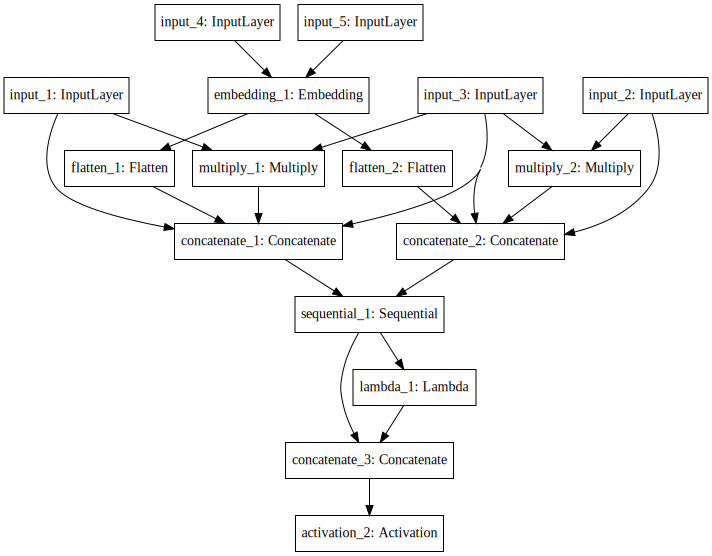

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
min_loss = 1.0
best_model = 0
# Use Kfold to get best model

from sklearn.model_selection import KFold
n_fold = 5
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=3)
for fold_n, (train_index, valid_index) in enumerate(kfold.split(X_train[0])):
    
    X_tr  = [inputs[train_index] for inputs in X_train]
    X_val = [inputs[valid_index] for inputs in X_train]
    y_tr  = np.asarray(y_train)[train_index]
    y_val = np.asarray(y_train)[valid_index]
    
    model = End2End_NCR(word_input_shape=X_train[0].shape[1], dist_shape=X_train[3].shape[1]).build()
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss="sparse_categorical_crossentropy")
    file_path = "best_model_{}.hdf5".format(fold_n+1)
    check_point = callbacks.ModelCheckpoint(file_path, monitor = "val_loss", verbose = 0, save_best_only = True, mode = "min")
    early_stop = callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience=100)
    hist = model.fit(X_tr, y_tr, batch_size=128, epochs=1000, validation_data=(X_val, y_val), verbose=0,
              shuffle=True, callbacks = [check_point, early_stop])
    
    if min(hist.history['val_loss']) < min_loss:
        min_loss = min(hist.history['val_loss'])
        best_model = fold_n + 1

Instructions for updating:
Use tf.cast instead.


In [17]:
del model

In [18]:
#Use best model to predict
model = End2End_NCR(word_input_shape=X_train[0].shape[1], dist_shape=X_train[3].shape[1]).build()
model.load_weights("./best_model_{}.hdf5".format(best_model))
pred = model.predict(x = X_test, verbose = 0)

sub_df_path = os.path.join('../input/gendered-pronoun-resolution/', 'sample_submission_stage_2.csv')
sub_df = pd.read_csv(sub_df_path)
sub_df.loc[:, 'A'] = pd.Series(pred[:, 0])
sub_df.loc[:, 'B'] = pd.Series(pred[:, 1])
sub_df.loc[:, 'NEITHER'] = pd.Series(pred[:, 2])

sub_df.head(20)

,ID,A,B,NEITHER
0,000075809a8e6b062f5fb3c191a8ed52,0.836955,0.120751,0.042294
1,0005d0f3b0a6c9ffbd31a48453029911,0.993733,0.000500,0.005767
2,0007775c40bedd4147a0573d66dc28f8,0.043715,0.925504,0.030781
3,001194e3fe1234d00198ef6bba4cc588,0.026327,0.733608,0.240065
4,0014bb7085278ef3f9b74f14771caca9,0.000168,0.999469,0.000363
5,002671a4f3ec8d724e0541c2f1a1f8cc,0.997507,0.001682,0.000811
6,002eb2ad27bbeab286b15650b8cb2c27,0.374600,0.044514,0.580886
7,002eebd91abbd53207da15ae61714531,0.330328,0.596830,0.072842
8,0034d8a107da2eeba335128665f6fc1f,0.000079,0.999391,0.000530
9,0034dfd350220409b621a5e3ac1c5e02,0.773379,0.194037,0.032584


In [19]:
from sklearn.metrics import log_loss
y_one_hot = np.zeros((2000, 3))
for i in range(len(y_test)):
    y_one_hot[i, y_test[i]] = 1
log_loss(y_one_hot, pred) # Calculate the log loss 

0.4838068183946834

In [20]:
sub_df.to_csv("submission.csv", index=False)